In [6]:
import argparse
import matplotlib 
matplotlib.use('Agg')
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import re

%matplotlib inline


# Update rate

In [7]:
200*24*365

1752000

In [8]:
f = open("sbtunnel-henry.log", "r")

changes = []
raw_lines = []
net = 0
total_changes = 0
for l in f.readlines():
    if re.match(r".*FETCH Response.*", l):
        #print(re.match(r".*FETCH.*", l))
        
        date_time_str = re.search(r"(.*) FETCH.*", l).group(1)
        date_time_obj = datetime.datetime.strptime(date_time_str, '%Y/%m/%d %H:%M:%S')
        ts = date_time_obj.timestamp()
        
        added = int(re.search(r"RiceHashes added: (\d+)", l).group(1))
        removed = 0
        if re.match(r".*FULL_UPDATE.*", l) == None:
            removed = int(re.search(r"RiceIndices removed: (\d+)", l).group(1))
            
        delta = added+removed
        net += added - removed
        total_changes += delta
        changes += [[ts, added, removed, delta, net, total_changes]]
        raw_lines += [l]

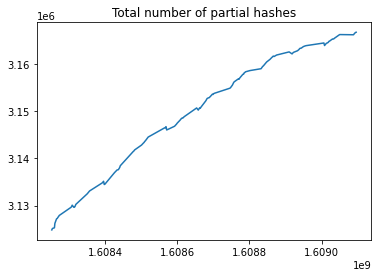

In [9]:
changes = np.array(changes)

plt.figure()
plt.title("Total number of partial hashes")
plt.plot(changes[:,0], changes[:,4])
plt.show()

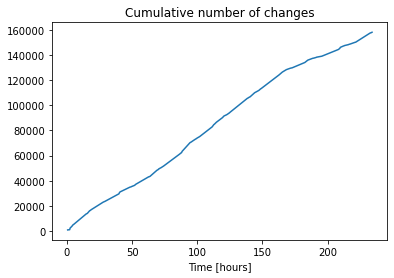

In [10]:
plt.figure()
plt.plot((changes[1:,0]-changes[0,0])/3600, changes[1:,5]-changes[0,5])
plt.title("Cumulative number of changes")
plt.xlabel("Time [hours]")
plt.show()

In [11]:
coef = np.polyfit(changes[:,0], changes[:,5],1)
print(f"Changes per hour: {coef[0]*3600}")

coef = np.polyfit(changes[1:,0]-changes[0,0], np.cumsum(changes[1:,1]),1)
print(f"Additions per hour: {coef[0]*3600}")

coef = np.polyfit(changes[1:,0]-changes[0,0], np.cumsum(changes[1:,2]),1)
print(f"Deletions per hour: {coef[0]*3600}")

Changes per hour: 702.5230983903118
Additions per hour: 440.54205930380533
Deletions per hour: 261.3946756233395


# Query rate

In [12]:
f = open("sbtunnel-henry.log", "r")

queries = []
for l in f.readlines():
    if re.match(r".*FIND Request.*", l):
        date_time_str = re.search(r"(.*) FIND.*", l).group(1)
        date_time_obj = datetime.datetime.strptime(date_time_str, '%Y/%m/%d %H:%M:%S')
        ts = date_time_obj.timestamp()
        
        q = int(re.search(r".*(\d+) prefixes", l).group(1))
            
        queries += [[ts, q]]

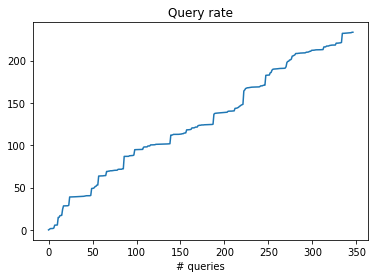

In [13]:
queries = np.array(queries)
plt.figure()
plt.plot((queries[:,0]-queries[0,0])/3600)
plt.title("Query rate")
plt.xlabel("# queries")
plt.show()

In [14]:
window_start = queries[0,0]
window_end = queries[1,0]
window_q = 0
windows = []
for q in queries:
    if (q[0] - window_end) > 10*60:
        windows += [[int((window_end-window_start)/60), window_q]]
        window_start = q[0]
        window_end = window_start
        window_q = 1
    else:
        window_end = q[0]
        window_q += 1
print(windows)

[[0, 1], [0, 1], [9, 4], [0, 1], [13, 4], [4, 2], [6, 2], [0, 1], [0, 1], [11, 6], [0, 1], [58, 18], [0, 1], [2, 5], [0, 1], [0, 1], [6, 2], [0, 1], [0, 1], [0, 1], [3, 2], [16, 6], [8, 3], [0, 2], [2, 2], [3, 3], [0, 1], [9, 5], [9, 5], [0, 2], [4, 6], [11, 3], [0, 2], [0, 1], [22, 10], [0, 1], [4, 4], [0, 3], [14, 6], [43, 17], [0, 2], [0, 1], [25, 10], [0, 2], [0, 1], [5, 2], [22, 5], [0, 1], [2, 3], [0, 1], [1, 3], [0, 1], [0, 1], [0, 2], [0, 3], [23, 10], [0, 1], [0, 1], [0, 1], [3, 2], [60, 12], [0, 1], [12, 6], [0, 1], [5, 2], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [2, 2], [0, 1], [0, 1], [18, 10], [0, 1], [10, 3], [0, 1], [0, 2], [21, 5], [0, 1], [0, 1], [0, 1], [0, 1], [56, 13], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [9, 2], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 3], [2, 2], [23, 7], [6, 3], [0, 1], [0, 2], [12, 4], [25, 10], [3, 3], [1, 3], [0, 1], [4, 2], [5, 5], [14, 5], [0, 1], [0, 1], [33, 8], [0, 3]]


In [53]:
windows = np.array(windows)
windows[:,0]/windows[:,1]

array([0.        , 0.        , 2.25      , 0.        , 3.25      ,
       2.        , 3.        , 0.        , 0.        , 1.83333333,
       0.        , 3.22222222, 0.        , 0.4       , 0.        ,
       0.        , 3.        , 0.        , 0.        , 0.        ,
       1.5       , 2.66666667, 2.66666667, 0.        , 1.        ,
       1.        , 0.        , 1.8       , 1.8       , 0.        ,
       0.66666667, 3.66666667, 0.        , 0.        , 2.2       ,
       0.        , 1.        , 0.        , 2.33333333, 2.52941176,
       0.        , 0.        , 2.5       , 0.        , 0.        ,
       2.5       , 4.4       , 0.        , 0.66666667, 0.        ,
       0.33333333, 0.        , 0.        , 0.        , 0.        ,
       2.3       , 0.        , 0.        , 0.        , 1.5       ,
       5.        , 0.        , 2.        , 0.        , 2.5       ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     